In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from scipy import stats
from scipy.stats import boxcox
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df = pd.read_csv('train_2.csv')

In [3]:
#Parsing Page column
def parse_page(x):
    x = x.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]

date_cols = [i for i in df.columns if i != 'Page']

df['name'], df['project'], df['access'], df['agent'] = zip(*df['Page'].apply(parse_page))

In [4]:
#Fill missing value with 0
df.fillna(0,inplace = True)

In [5]:
#Sum visit counts by project
df.groupby('project').agg(lambda x: x.iloc[1:-3].sum())

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,name,access,agent
project,,,,,,,,,,,,,,,,,,,,,
commons.wikimedia.org,Atlas_of_Asia_commons.wikimedia.org_all-access...,1140766.0,1178082.0,1150503.0,951282.0,1057990.0,1210018.0,1261800.0,1396996.0,1211789.0,...,2152828.0,1773835.0,4697284.0,10781045.0,1982210.0,2101966.0,1784688.0,Atlas of AsiaAtlas of EuropeAtlas of World War...,all-accessall-accessall-accessall-accessall-ac...,spiderspiderspiderspiderspiderspiderspiderspid...
de.wikipedia.org,11._November_de.wikipedia.org_all-access_spide...,13260519.0,13079896.0,12554042.0,11520379.0,13392347.0,14741758.0,14296292.0,14505194.0,13964778.0,...,12470231.0,12137502.0,12373017.0,14257604.0,11705354.0,10902161.0,12182962.0,11. November12 Monkeys187 Strassenbande1944 (L...,all-accessall-accessall-accessall-accessall-ac...,spiderspiderspiderspiderspiderspiderspiderspid...
en.wikipedia.org,"""Awaken,_My_Love!""_en.wikipedia.org_desktop_al...",84712169.0,84438530.0,80167709.0,83463178.0,86198611.0,92809415.0,87838032.0,82880177.0,84798897.0,...,99433145.0,93005187.0,92862917.0,97701957.0,74417792.0,71919643.0,75370684.0,"""Awaken, My Love!""""European Society for Clinic...",desktopdesktopdesktopdesktopdesktopdesktopdesk...,all-agentsall-agentsall-agentsall-agentsall-ag...
es.wikipedia.org,10_Cloverfield_Lane_es.wikipedia.org_desktop_a...,15278163.0,14600620.0,13427341.0,12606317.0,13710118.0,15624433.0,15230360.0,14781537.0,14502540.0,...,17039941.0,18045620.0,17409747.0,16786089.0,14395827.0,11635190.0,13516521.0,10 Cloverfield Lane12 de octubre13 de septiemb...,desktopdesktopdesktopdesktopdesktopdesktopdesk...,all-agentsall-agentsall-agentsall-agentsall-ag...
fr.wikipedia.org,1984_(roman)_fr.wikipedia.org_desktop_all-agen...,8458638.0,8512952.0,8186030.0,8749842.0,8590493.0,8949799.0,8650800.0,8491533.0,8403646.0,...,8173259.0,7982899.0,9222432.0,9067000.0,8004503.0,8444802.0,9111852.0,1984 (roman)24 Heures du Mans24 Heures du Mans...,desktopdesktopdesktopdesktopdesktopdesktopdesk...,all-agentsall-agentsall-agentsall-agentsall-ag...
ja.wikipedia.org,A.B.C-Z_ja.wikipedia.org_mobile-web_all-agents...,11863098.0,13620677.0,12304532.0,15455671.0,14826910.0,12920318.0,12568683.0,12492661.0,12178085.0,...,11785274.0,11350129.0,11695341.0,12963018.0,11689940.0,12497221.0,13937535.0,A.B.C-ZACE OF SPADESALEXANDERALL OUT!!ASIAN KU...,mobile-webmobile-webmobile-webmobile-webmobile...,all-agentsall-agentsall-agentsall-agentsall-ag...
ru.wikipedia.org,5sta_Family_ru.wikipedia.org_mobile-web_all-ag...,9462984.0,9626742.0,8922429.0,8392441.0,8937769.0,9628120.0,9407353.0,9363192.0,9591399.0,...,9444425.0,11479733.0,14970530.0,10459777.0,9034001.0,9197638.0,10066733.0,5sta FamilyABBAAdidasAlekseevAndroidAppleAvito...,mobile-webmobile-webmobile-webmobile-webmobile...,all-agentsall-agentsall-agentsall-agentsall-ag...
www.mediawiki.org,2017_wikitext_editor_www.mediawiki.org_all-acc...,349713.0,383680.0,325714.0,308756.0,338485.0,391894.0,433312.0,372333.0,331655.0,...,1220992.0,1295583.0,4123685.0,3500768.0,502436.0,414020.0,428477.0,2017 wikitext editor2017 wikitext editor/Feedb...,all-accessall-accessall-accessall-accessall-ac...,all-agentsall-agentsall-agentsall-agentsall-ag...
zh.wikipedia.org,2PM_zh.wikipedia.org_all-access_spider3C_zh.wi...,4144970.0,4151178.0,4123654.0,4163435.0,4441272.0,4464281.0,4459412.0,4575820.0,4547817.0,...,5068253.0,5117410.0,4993281.0,5205129.0,5018866.0,5243805.0,5459078.0,2PM3C4minute52 Hz I Love You556691DaysA'N'DAKB...,all-accessall-accessall-accessall-accessall-ac...,spiderspiderspiderspiderspiderspiderspiderspid...


In [6]:
#remove other variables
df_project = pd.concat([df.iloc[:,1:-4],df[['project']]],axis = 1).groupby('project').sum().reset_index()

In [7]:
#Deploy ACF, PACF and QQ plot
def ts_plot(data, lags=None,title=''):
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0),colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'Web Traffic')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('ACF')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('PACF')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        plt.tight_layout()
        plt.tight_layout()
    return

In [8]:
#Transpose the format of dataframe
df_project_melt = df_project.melt(id_vars=["project"], 
        var_name="Date", 
        value_name="Visit_count")

In [9]:
df_project_name = df_project_melt['project'].unique()

In [10]:
#Slicing dataframe by project
dict_of_df = {}
df_name = []
for i in range(len(df_project_name)):    
    key_name = 'df_{}'.format(df_project_name[i].split('.')[0])
    dict_of_df[key_name] = df_project_melt[(df_project_melt['project']==df_project_name[i])].reset_index()
    df_name.append(key_name)

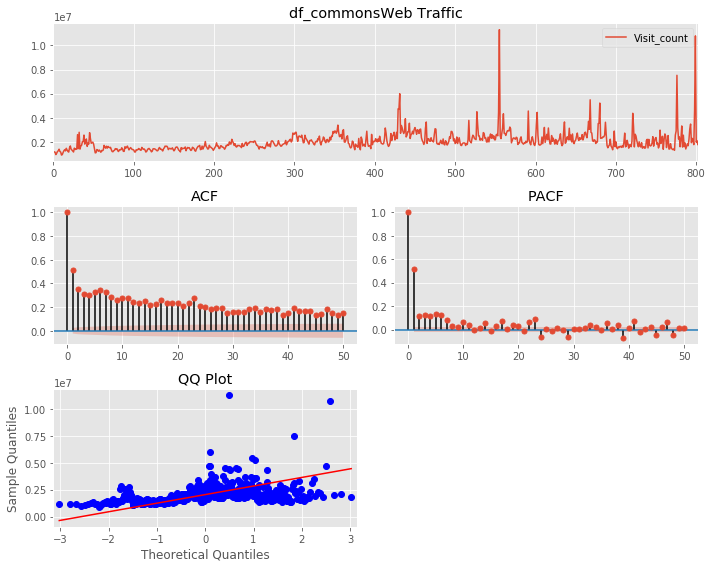

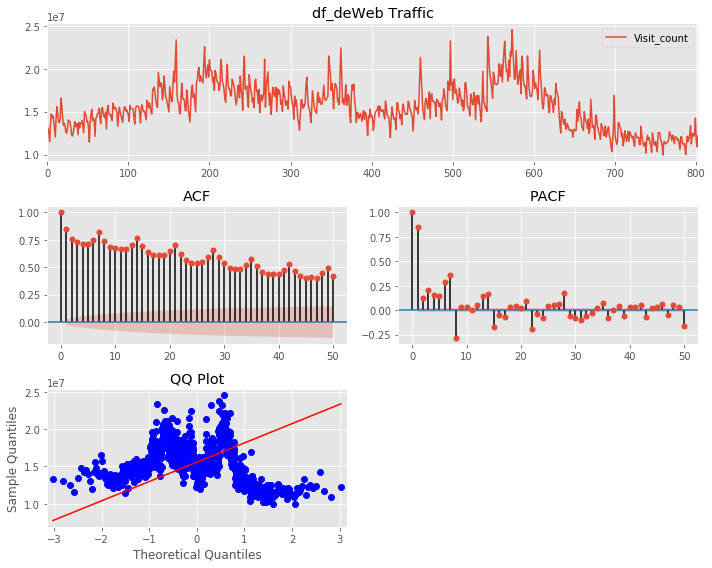

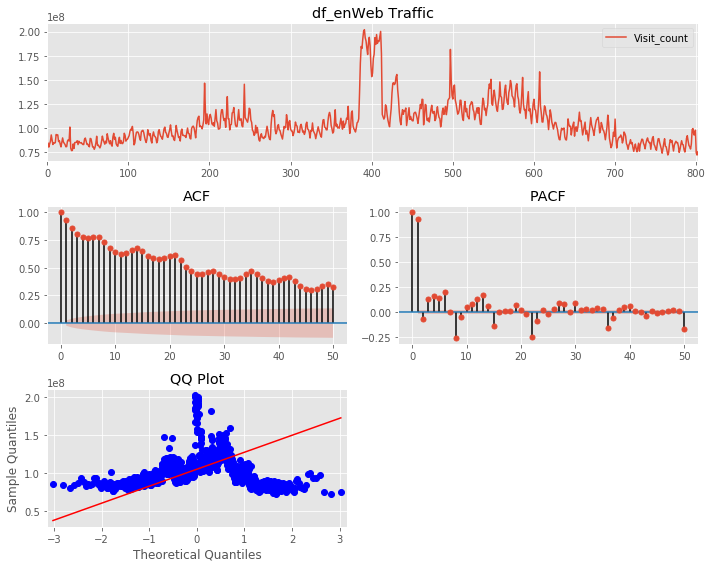

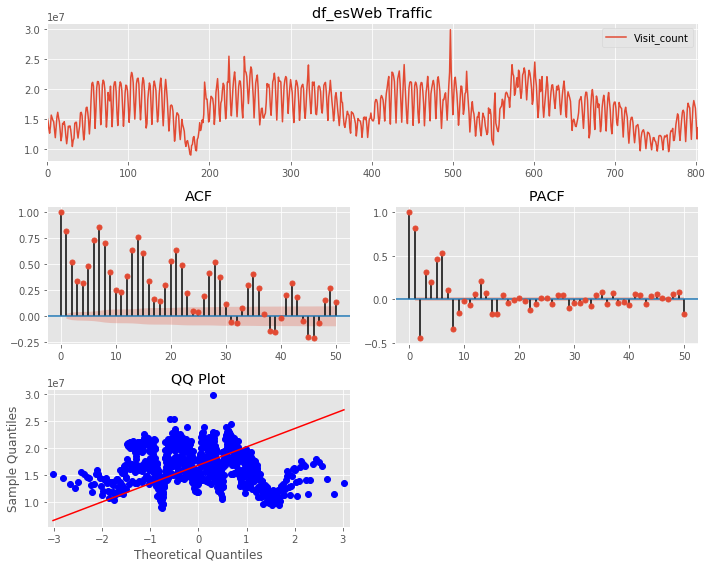

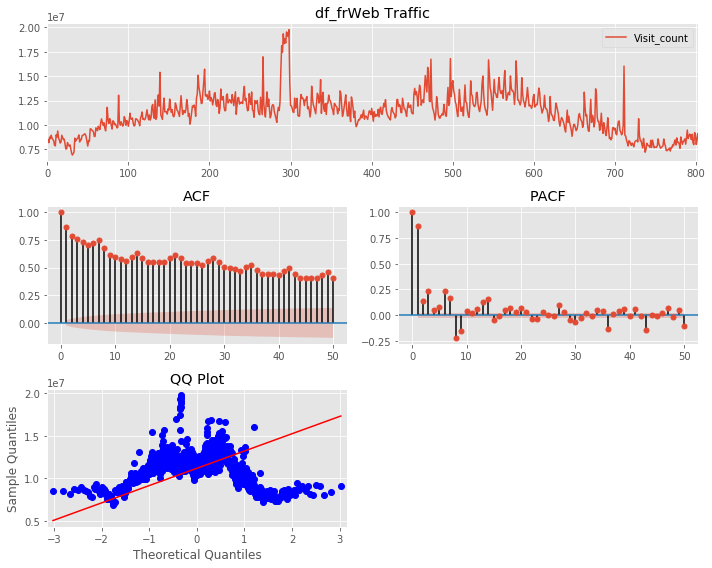

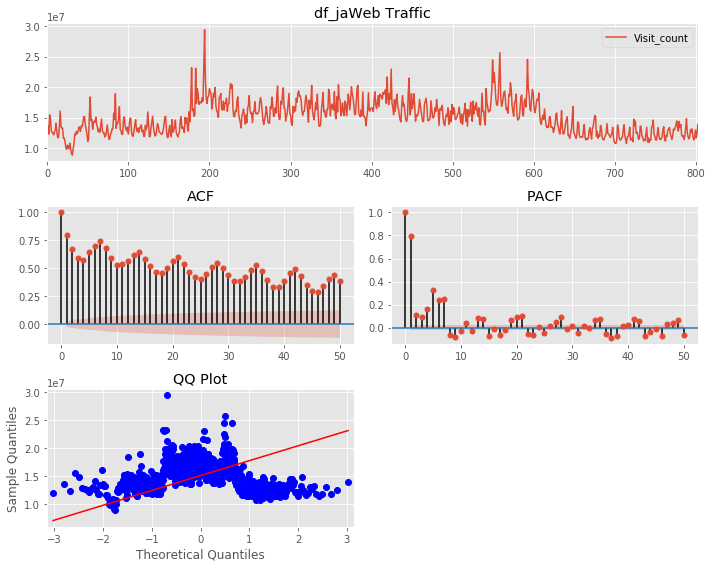

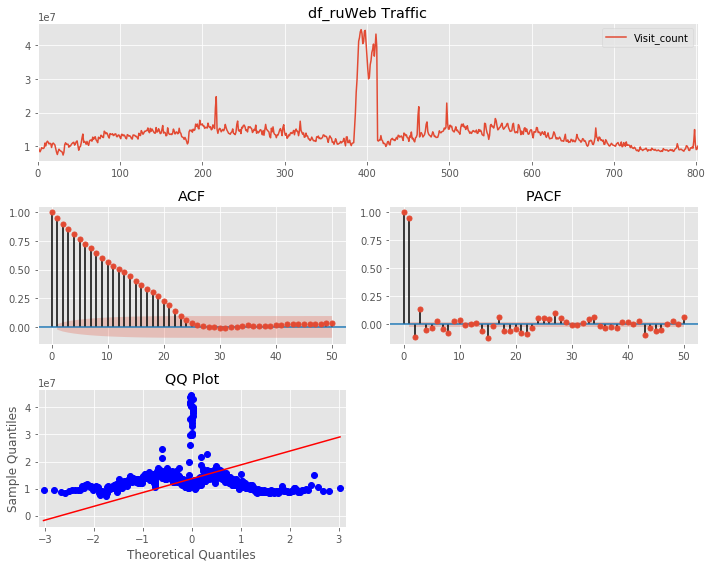

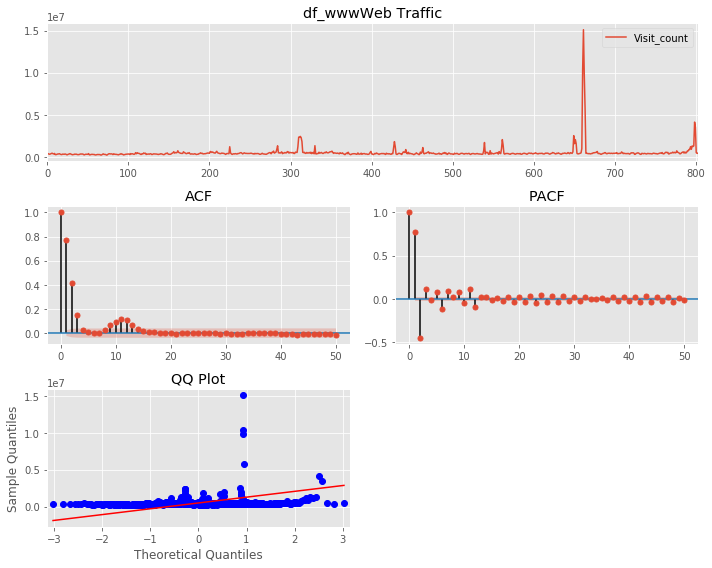

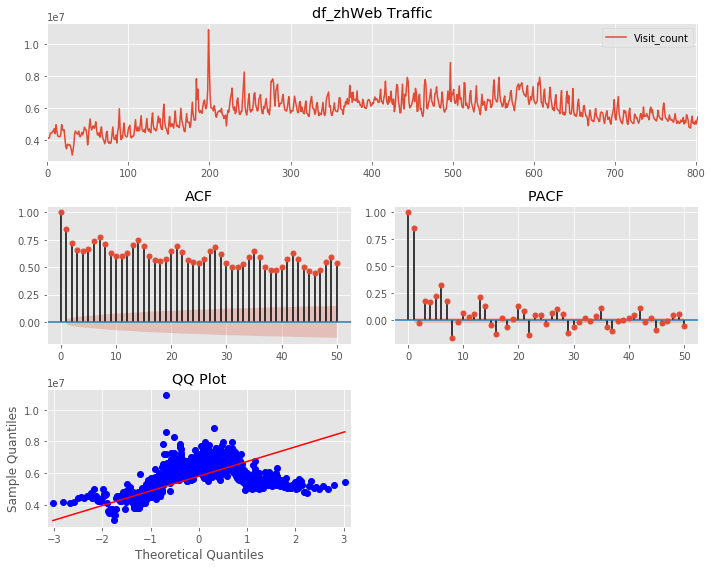

In [11]:
#Creating graphs of each project
for i in df_name:
    ts_plot(dict_of_df[i][['Visit_count']],lags = 50, title = i)

Based on the ACF and PACF graphs, we decide to use the data of project "es.wikipedia.org" to fit the time series data in the first phase of the project.

In [12]:
#log transform the data
dict_of_df['df_es']['Visit_count'] = dict_of_df['df_es']['Visit_count'].apply(lambda x:np.math.log(x))

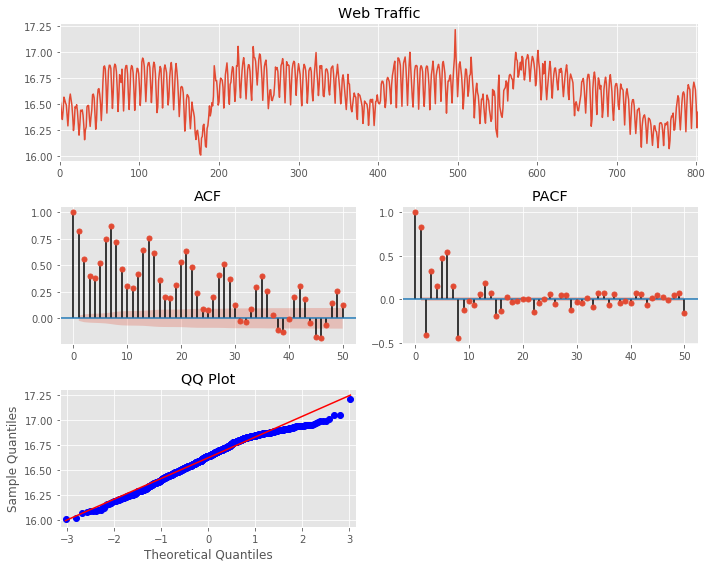

In [13]:
ts_plot(dict_of_df['df_es']['Visit_count'],lags = 50)

In [14]:
def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [15]:
test_stationarity(dict_of_df['df_es']['Visit_count'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.791241
p-value                          0.002998
#Lags Used                      21.000000
Number of Observations Used    781.000000
Critical Value (1%)             -3.438751
Critical Value (5%)             -2.865248
Critical Value (10%)            -2.568744
dtype: float64


In [16]:
#Split the data into train & test, train data set (2015-07-01 to 2017-07-01), test data set (2017-07-02 to 2017-09-10)
df_es = dict_of_df['df_es']
train = dict_of_df['df_es'].iloc[:732,:] 
test = dict_of_df['df_es'].iloc[732:,:]

## Fit AR Model

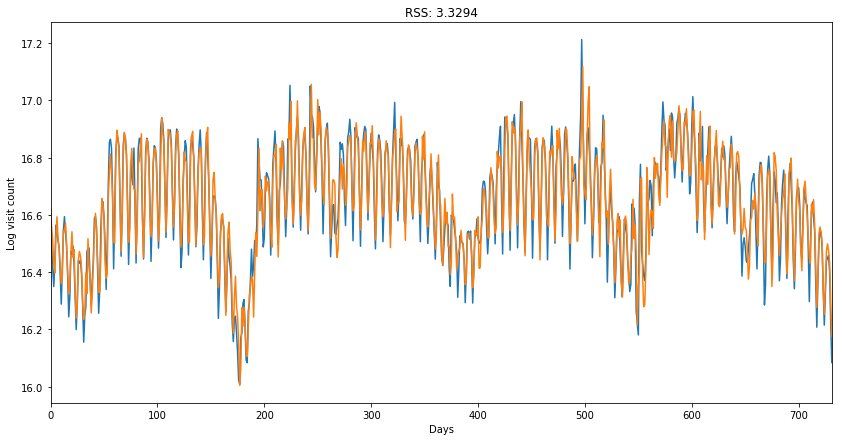

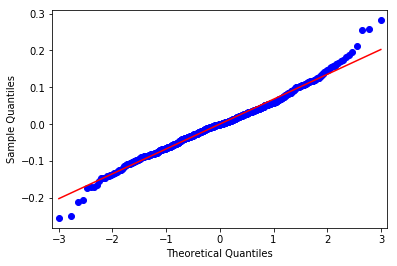

In [17]:
#Build AR Model(setting q=0),(p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.
model = ARIMA(train[['Visit_count']], order=(8, 0, 0))  
results_AR = model.fit(disp=-1)
resid=pd.Series(results_AR.resid,index=train.index)
#Plot
ax = train['Visit_count'].plot(label='observed', figsize=(14, 7))
results_AR.fittedvalues.plot(ax=ax, label='Forecast')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-train['Visit_count'])**2))
sm.qqplot(resid, line='s')
ax.set_xlabel('Days')
ax.set_ylabel('Log visit count')
plt.show()

In [18]:
#Get model report
results_AR.summary().tables[0]

Dep. Variable:,Visit_count,No. Observations:,732
Model:,"ARMA(8, 0)",Log Likelihood,933.955
Method:,css-mle,S.D. of innovations,0.067
Date:,"Thu, 14 Nov 2019",AIC,-1847.911
Time:,03:53:09,BIC,-1801.953
Sample:,0,HQIC,-1830.182
,,,


In [19]:
results_AR.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,16.6244,0.049,337.682,0.000,16.528,16.721
ar.L1.Visit_count,0.9044,0.033,27.044,0.000,0.839,0.970
ar.L2.Visit_count,-0.2887,0.044,-6.628,0.000,-0.374,-0.203
ar.L3.Visit_count,0.1573,0.044,3.568,0.000,0.071,0.244
ar.L4.Visit_count,-0.0918,0.045,-2.058,0.040,-0.179,-0.004
ar.L5.Visit_count,-0.0124,0.044,-0.280,0.780,-0.100,0.075
ar.L6.Visit_count,0.2145,0.044,4.867,0.000,0.128,0.301
ar.L7.Visit_count,0.4927,0.043,11.339,0.000,0.408,0.578
ar.L8.Visit_count,-0.4250,0.033,-12.697,0.000,-0.491,-0.359


Text(0.5, 1.0, 'RSS: 4.6190')

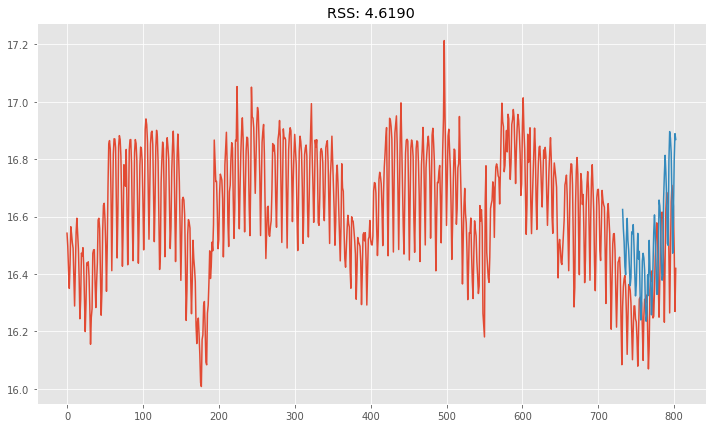

In [20]:
#Prediction on test data set
pred = results_AR.predict(start=0,end =70 , dynamic=False)
pf = pd.Series(pred.values,test.index)
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,7))
plt.plot(df_es[['Visit_count']])
plt.plot(pf)
plt.title('RSS: %.4f'% sum(((pf-test['Visit_count'])**2)))

In [21]:
#Searching best Lag for AR Model
for i in range(20):
    model = ARIMA(train[['Visit_count']], order=(i, 0, 0))
    results_AR = model.fit(disp=-1)
    rss = sum((results_AR.fittedvalues-train['Visit_count'])**2)
    print(results_AR.summary().tables[0],'RSS: %.4f'% rss)

                              ARMA Model Results                              
Dep. Variable:            Visit_count   No. Observations:                  732
Model:                     ARMA(0, 0)   Log Likelihood                 160.019
Method:                           css   S.D. of innovations              0.194
Date:                Thu, 14 Nov 2019   AIC                           -316.039
Time:                        03:53:12   BIC                           -306.847
Sample:                             0   HQIC                          -312.493
                                                                              
============================================================================== RSS: 27.6795
                              ARMA Model Results                              
Dep. Variable:            Visit_count   No. Observations:                  732
Model:                     ARMA(1, 0)   Log Likelihood                 530.887
Method:                       css-mle  

                              ARMA Model Results                              
Dep. Variable:            Visit_count   No. Observations:                  732
Model:                    ARMA(11, 0)   Log Likelihood                 942.072
Method:                       css-mle   S.D. of innovations              0.066
Date:                Thu, 14 Nov 2019   AIC                          -1858.144
Time:                        03:53:33   BIC                          -1798.399
Sample:                             0   HQIC                         -1835.097
                                                                              
============================================================================== RSS: 3.2583
                              ARMA Model Results                              
Dep. Variable:            Visit_count   No. Observations:                  732
Model:                    ARMA(12, 0)   Log Likelihood                 943.533
Method:                       css-mle   

/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Visit_count   No. Observations:                  732
Model:                    ARMA(17, 0)   Log Likelihood                 980.619
Method:                       css-mle   S.D. of innovations              0.063
Date:                Thu, 14 Nov 2019   AIC                          -1923.238
Time:                        03:57:27   BIC                          -1835.918
Sample:                             0   HQIC                         -1889.554
                                                                              
============================================================================== RSS: 2.9310
                              ARMA Model Results                              
Dep. Variable:            Visit_count   No. Observations:                  732
Model:                    ARMA(18, 0)   Log Likelihood                 980.881
Method:                       css-mle   

## Fit ARIMA MODEL

In [22]:
#Grid search for best order of ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order)
                    results_ARIMA = model.fit(disp=-1)
                    mse = sum((results_ARIMA.fittedvalues-dataset)**2)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [23]:
#Set p, d, q range
p_values = [0, 1, 2, 4, 6, 8, 9, 10]
d_values = [0]
q_values = range(0, 4)
evaluate_models(train['Visit_count'].values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=27.679
ARIMA(0, 0, 1) MSE=11.267
ARIMA(1, 0, 0) MSE=10.041
ARIMA(1, 0, 1) MSE=7.712
ARIMA(1, 0, 2) MSE=7.624
ARIMA(1, 0, 3) MSE=6.969
ARIMA(2, 0, 0) MSE=8.177
ARIMA(2, 0, 1) MSE=7.644
ARIMA(2, 0, 2) MSE=7.229
ARIMA(2, 0, 3) MSE=6.957
ARIMA(4, 0, 0) MSE=7.313
ARIMA(4, 0, 1) MSE=6.008
ARIMA(4, 0, 2) MSE=4.549


/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 0, 3) MSE=4.489
ARIMA(6, 0, 0) MSE=4.133
ARIMA(6, 0, 1) MSE=4.103
ARIMA(6, 0, 2) MSE=3.486
ARIMA(6, 0, 3) MSE=3.456
ARIMA(8, 0, 0) MSE=3.329
ARIMA(8, 0, 1) MSE=3.273
ARIMA(8, 0, 2) MSE=3.273
ARIMA(8, 0, 3) MSE=3.262
ARIMA(9, 0, 0) MSE=3.277
ARIMA(9, 0, 1) MSE=3.273
ARIMA(9, 0, 2) MSE=3.235
ARIMA(9, 0, 3) MSE=3.153
ARIMA(10, 0, 0) MSE=3.274
ARIMA(10, 0, 1) MSE=3.273


/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(10, 0, 2) MSE=8567487.470


/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


ARIMA(10, 0, 3) MSE=3.006
Best ARIMA(10, 0, 3) MSE=3.006


/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/lindy/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


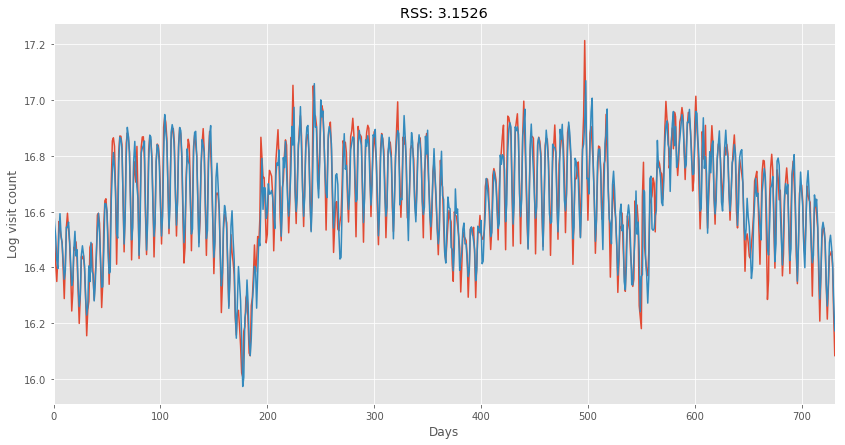

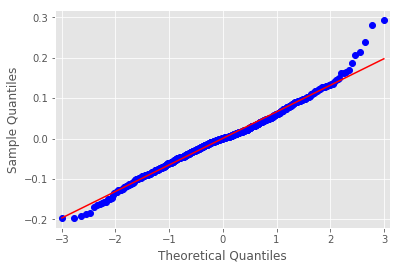

In [24]:
#Build ARIMA model, (p,d,q) order of the model for the number of AR parameters, differences, and MA parameters to use.
model = ARIMA(train[['Visit_count']], order=(9, 0, 3))  
results_ARIMA = model.fit(disp=-1)
resid=pd.Series(results_ARIMA.resid,index=train.index)
#Plot result
ax = train['Visit_count'].plot(label='observed', figsize=(14, 7))
results_ARIMA.fittedvalues.plot(ax=ax, label='Forecast')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-train['Visit_count'])**2))
sm.qqplot(resid, line='s')
ax.set_xlabel('Days')
ax.set_ylabel('Log visit count')
plt.show()

Text(0.5, 1.0, 'RSS: 4.4868')

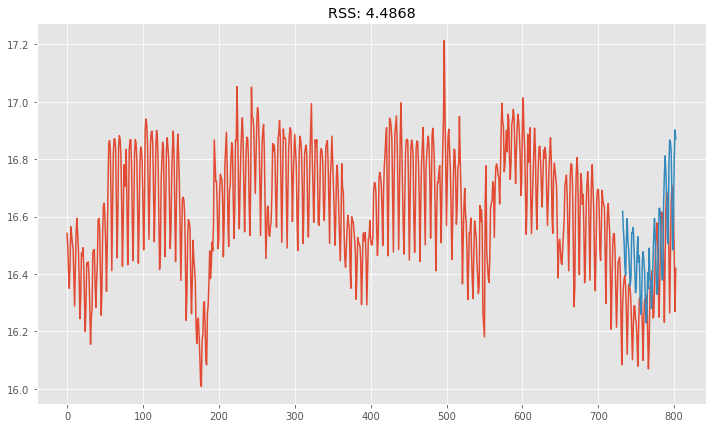

In [25]:
#Prediction on test data set
pred = results_ARIMA.predict(start=0,end =70 , dynamic=False)
pf = pd.Series(pred.values,test.index)
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,7))
plt.plot(df_es[['Visit_count']])
plt.plot(pf)
plt.title('RSS: %.4f'% sum(((pf-test['Visit_count'])**2)))

In [26]:
#Get model report
results_ARIMA.summary().tables[0]

Dep. Variable:,Visit_count,No. Observations:,732
Model:,"ARMA(9, 3)",Log Likelihood,953.595
Method:,css-mle,S.D. of innovations,0.065
Date:,"Thu, 14 Nov 2019",AIC,-1879.189
Time:,07:25:14,BIC,-1814.848
Sample:,0,HQIC,-1854.369
,,,


In [27]:
results_ARIMA.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,16.6183,0.056,299.012,0.000,16.509,16.727
ar.L1.Visit_count,1.4825,0.094,15.811,0.000,1.299,1.666
ar.L2.Visit_count,-1.0001,0.165,-6.078,0.000,-1.323,-0.678
ar.L3.Visit_count,0.2386,0.166,1.435,0.152,-0.087,0.565
ar.L4.Visit_count,0.0028,0.126,0.022,0.983,-0.243,0.249
ar.L5.Visit_count,-0.0827,0.089,-0.929,0.353,-0.257,0.092
ar.L6.Visit_count,0.3042,0.074,4.104,0.000,0.159,0.449
ar.L7.Visit_count,0.2426,0.076,3.208,0.001,0.094,0.391
ar.L8.Visit_count,-0.5111,0.071,-7.249,0.000,-0.649,-0.373
ar.L9.Visit_count,0.2834,0.044,6.425,0.000,0.197,0.370
